In [23]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [24]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta, date

# Reflect Tables into SQLAlchemy ORM

In [25]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [26]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [27]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [28]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [29]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [30]:
# Create our session (link) from Python to the DB
session = Session(engine)

##  Explore Database

In [31]:
## View table details
Base.metadata.tables

immutabledict({'measurement': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), 'station': Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)})

In [32]:
# get the table names (same result as: Base.classes.keys() )
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [33]:
# for first table, get a list of column names and types in a more pleasing format
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [34]:
# for second table, get a list of column names and types in a more pleasing format
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [35]:
# for the first table, view the data structure
engine.execute('select * from measurement limit 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [36]:
engine.execute('select * from station limit 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Precipitation Analysis

In [37]:
# Find the most recent date in the data set.
# recent_date_str = session.query(measurement.date).order_by(measurement.date.desc()).first()
# recent_date_str


In [38]:
# Find the most recent date in the data set.
recent_date_str = session.query(func.max(measurement.date)).one()[0]
recent_date_str

'2017-08-23'

In [39]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
for recent_date in recent_date_str:    
    recent_date = dt.datetime.strptime(recent_date_str, "%Y-%m-%d")
recent_date

# Calculate the date one year from the last date in data set.
one_year_ago = recent_date - timedelta(days=365)
one_year_ago

# Perform a query to retrieve the data and precipitation scores
precipitations_query = session.query(measurement.date, measurement.prcp)
precipitations_query

## Filter and extract the data to include only the past year's of precipitations
past_year_precipitations_query = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()
past_year_precipitations_query

#for r in past_year_precipitations_query:
#    print(r)
                                               
                                               
# # Save the query results as a Pandas DataFrame and set the index to the date column
past_year_precipitations_df = pd.DataFrame(past_year_precipitations_query, columns=['date','precipitation'])
past_year_precipitations_df.set_index(past_year_precipitations_df['date'], inplace=True)

# # Sort the dataframe by date
past_year_precipitations_df.sort_index()
past_year_precipitations_df



,date,precipitation
date,,
2016-08-24,2016-08-24,0.08
2016-08-25,2016-08-25,0.08
2016-08-26,2016-08-26,0.00
2016-08-27,2016-08-27,0.00
2016-08-28,2016-08-28,0.01
...,...,...
2017-08-19,2017-08-19,0.09
2017-08-20,2017-08-20,NaN
2017-08-21,2017-08-21,0.56


Text(0.5, 0.98, 'Past Year Precipitations')

<Figure size 576x432 with 0 Axes>

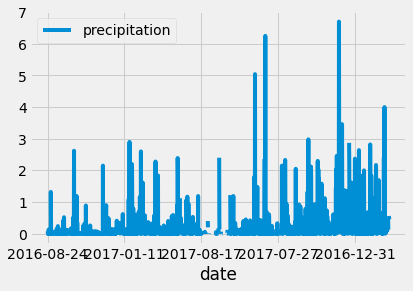

In [40]:
# Use Pandas Plotting with Matplotlib to plot the data
fig=plt.figure(figsize=(8,6))

past_year_precipitations_df.plot()
fig.suptitle('Past Year Precipitations', fontweight ="bold") 

# plt.show()

In [41]:
# Use Pandas to calculate the summary statistics for the precipitation data
past_year_precipitations_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [75]:
# Design a query to calculate the total number stations in the dataset
total_number_of_stations = session.query(station.station).group_by(station.station).all()
total_number_of_stations_no = len(total_number_of_stations)
total_number_of_stations_no

9

In [92]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(measurement.station, func.count(measurement.station)).\
                       group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [102]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(measurement.station).\
                       group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()

print(f'{most_active_station} has the greatest number of observations with statistics as follows: ')

station_statistics = session.query(func.min(measurement.prcp), func.max(measurement.prcp), func.avg(measurement.prcp))
print({station_statistics})

('USC00519281',) has the greatest number of observations with statistics as follows: 
{<sqlalchemy.orm.query.Query object at 0x000001C6561F2D88>}


In [45]:
# Using the most active station id
## join to get station name




# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [46]:
# Close Session
session.close()